In [ ]:
# [collapse: code] Colab Setup (Install Dependencies)
# This cell installs the dependencies defined in your pyproject.toml
import os

# Only run this if we are in Google Colab
if 'google.colab' in os.environ:
    print("Installing dependencies from pyproject.toml...")
    # This installs the repo itself (and its dependencies)
    !pip install -q "git+https://github.com/smec-ethz/tatva-docs.git"
    
    # Enable the widget manager for PyVista/Trame
    from google.colab import output
    output.enable_custom_widget_manager()
    
    print("Installation complete!")

# Quasistatic fracture using Cohesive Elements

In this notebook, we simulate crack propagation in a plate under quasistatic
loading.


In [ ]:
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")

import os
from typing import Callable, NamedTuple, Optional, Tuple

import equinox as eqx
import gmsh
import jax.numpy as jnp
import matplotlib.pyplot as plt
import meshio
import numpy as np
import pyvista as pv
from jax import Array
from jax_autovmap import autovmap
from tatva import Mesh, Operator, element, sparse
from tatva.plotting import plot_element_values, plot_nodal_values

pv.set_jupyter_backend("client")

The critical length for plain strain condition is given by:

$$L_\text{G} = 2\mu \Gamma/\pi(1-\nu)\sigma_{\infty}^2$$

where $\mu$ is the shear modulus, $\Gamma$ is the fracture energy, $\nu$ is the
Poisson's ratio, and $\sigma_{\infty}$ is the stress at infinity.

For plain strain condition, the effective Young's modulus is given by:

$$E_\text{eff} = \frac{E}{1-\nu^2}$$

where $E$ is the Young's modulus and $\nu$ is the Poisson's ratio.

For a specimen stretched by a prestrain $\epsilon$, the applied stress at
infinity is given by:

$$\sigma_{\infty} = \epsilon /E_\text{eff}$$


## Pre-crack plate under Mode I loading {#sec-plate-mode-I}

We generate a plate with a pre-crack of length $L_G$ and the cohesive interface
lies at $x \geq L_G$ and $y=0$.


In [3]:
# [collapse: code] View mesh generation functions

def generate_unstructured_hex_fracture_3d(
    length: float,
    height: float,
    thickness: float,
    crack_tip_x: float,
    mesh_size_tip: float,
    mesh_size_far: float,
    work_dir: str = "../meshes",
):
    """
    Generates a 3D fracture assembly with an Unstructured HEXAHEDRAL mesh.

    Args:
        length: Total length of the block (L)
        height: Total height of the block (h)
        thickness: Thickness of the block (t)
        crack_tip_x: X-coordinate of the crack tip (a)
        mesh_size_tip: Desired mesh size near the crack tip (refined)
        mesh_size_far: Desired mesh size far from the crack tip (coarser)
        work_dir: Directory to store temporary mesh files
    Returns:
        mesh: The full 3D mesh of the half-block (Mesh object)
        interface_mesh: The mesh representing the crack interface (Mesh object)
        top_interface_nodes: Node indices on the top face of the interface
        bottom_interface_nodes: Node indices on the bottom face of the interface
        active_quads_top: Quad element indices on the top face of the interface
        active_quads_bottom: Quad element indices on the bottom face of the interface
    """
    
    if not os.path.exists(work_dir):
        os.makedirs(work_dir)
    
    filename = os.path.join(work_dir, "temp_half_block_hex.msh")
    
    gmsh.initialize()
    gmsh.model.add("half_block_hex")
    
    h_half = height / 2.0
        
    # Points: Bottom Face (y=0)
    p1 = gmsh.model.geo.addPoint(0, 0, 0, mesh_size_far)
    p4 = gmsh.model.geo.addPoint(0, 0, thickness, mesh_size_far)
    # x=crack_tip (Refined)
    pt1 = gmsh.model.geo.addPoint(crack_tip_x, 0, 0, mesh_size_tip)
    pt2 = gmsh.model.geo.addPoint(crack_tip_x, 0, thickness, mesh_size_tip)
    # x=L
    p2 = gmsh.model.geo.addPoint(length, 0, 0, mesh_size_tip)
    p3 = gmsh.model.geo.addPoint(length, 0, thickness, mesh_size_tip)

    # Points: Top Face (y=h/2)
    p5 = gmsh.model.geo.addPoint(0, h_half, 0, mesh_size_far)
    p8 = gmsh.model.geo.addPoint(0, h_half, thickness, mesh_size_far)
    # x=crack_tip (Refined)
    pt3 = gmsh.model.geo.addPoint(crack_tip_x, h_half, 0, mesh_size_far)
    pt4 = gmsh.model.geo.addPoint(crack_tip_x, h_half, thickness, mesh_size_far)
    # x=L
    p6 = gmsh.model.geo.addPoint(length, h_half, 0, mesh_size_far)
    p7 = gmsh.model.geo.addPoint(length, h_half, thickness, mesh_size_far)

    # Lines: Bottom
    l1 = gmsh.model.geo.addLine(p1, pt1)
    l2 = gmsh.model.geo.addLine(pt1, p2)
    l_right_b = gmsh.model.geo.addLine(p2, p3)
    l3 = gmsh.model.geo.addLine(p3, pt2)
    l4 = gmsh.model.geo.addLine(pt2, p4)
    l_left_b = gmsh.model.geo.addLine(p4, p1)
    l_crack_b = gmsh.model.geo.addLine(pt1, pt2) # Crack front

    # Lines: Top
    l5 = gmsh.model.geo.addLine(p5, pt3)
    l6 = gmsh.model.geo.addLine(pt3, p6)
    l_right_t = gmsh.model.geo.addLine(p6, p7)
    l7 = gmsh.model.geo.addLine(p7, pt4)
    l8 = gmsh.model.geo.addLine(pt4, p8)
    l_left_t = gmsh.model.geo.addLine(p8, p5)
    l_crack_t = gmsh.model.geo.addLine(pt3, pt4)

    # Lines: Vertical
    v1 = gmsh.model.geo.addLine(p1, p5)
    v_tip1 = gmsh.model.geo.addLine(pt1, pt3)
    v2 = gmsh.model.geo.addLine(p2, p6)
    v3 = gmsh.model.geo.addLine(p3, p7)
    v_tip2 = gmsh.model.geo.addLine(pt2, pt4)
    v4 = gmsh.model.geo.addLine(p4, p8)

    # Surfaces (Pre/Post Crack Split)
    loop_if_1 = gmsh.model.geo.addCurveLoop([l1, l_crack_b, l4, l_left_b])
    s_if_1 = gmsh.model.geo.addPlaneSurface([loop_if_1])
    
    loop_if_2 = gmsh.model.geo.addCurveLoop([l2, l_right_b, l3, -l_crack_b])
    s_if_2 = gmsh.model.geo.addPlaneSurface([loop_if_2])

    loop_top_1 = gmsh.model.geo.addCurveLoop([l5, l_crack_t, l8, l_left_t])
    s_top_1 = gmsh.model.geo.addPlaneSurface([loop_top_1])
    
    loop_top_2 = gmsh.model.geo.addCurveLoop([l6, l_right_t, l7, -l_crack_t])
    s_top_2 = gmsh.model.geo.addPlaneSurface([loop_top_2])

    # Sides
    s_left = gmsh.model.geo.addPlaneSurface([gmsh.model.geo.addCurveLoop([l_left_b, v1, -l_left_t, -v4])])
    s_right = gmsh.model.geo.addPlaneSurface([gmsh.model.geo.addCurveLoop([l_right_b, v3, -l_right_t, -v2])])
    s_front_1 = gmsh.model.geo.addPlaneSurface([gmsh.model.geo.addCurveLoop([l1, v_tip1, -l5, -v1])])
    s_front_2 = gmsh.model.geo.addPlaneSurface([gmsh.model.geo.addCurveLoop([l2, v2, -l6, -v_tip1])])
    s_back_1 = gmsh.model.geo.addPlaneSurface([gmsh.model.geo.addCurveLoop([l4, v4, -l8, -v_tip2])])
    s_back_2 = gmsh.model.geo.addPlaneSurface([gmsh.model.geo.addCurveLoop([l3, v_tip2, -l7, -v3])])
    s_mid = gmsh.model.geo.addPlaneSurface([gmsh.model.geo.addCurveLoop([l_crack_b, v_tip2, -l_crack_t, -v_tip1])])

    # Volumes
    sl1 = gmsh.model.geo.addSurfaceLoop([s_if_1, s_top_1, s_left, s_front_1, s_back_1, s_mid])
    vol1 = gmsh.model.geo.addVolume([sl1])
    sl2 = gmsh.model.geo.addSurfaceLoop([s_if_2, s_top_2, s_right, s_front_2, s_back_2, s_mid])
    vol2 = gmsh.model.geo.addVolume([sl2])

    gmsh.model.geo.synchronize()

    gmsh.model.addPhysicalGroup(2, [s_if_1, s_if_2], 1, name="interface_surface")
    gmsh.model.addPhysicalGroup(3, [vol1, vol2], 2, name="top_domain")
    gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 2)
    
    gmsh.model.mesh.generate(3)
    gmsh.write(filename)
    gmsh.finalize()

    _m = meshio.read(filename)
    if os.path.exists(filename):
        os.remove(filename)

    points_top = _m.points # (N, 3)
    
    hex_top = _m.cells_dict["hexahedron"]
    
    interface_surf_idx = _m.cell_sets_dict["interface_surface"]["quad"]
    all_interface_quads_top = _m.cells_dict["quad"][interface_surf_idx]

    points_bottom = points_top.copy()
    points_bottom[:, 1] *= -1 # Flip Y
    points_bottom[:, 1] -= 1e-7
    
    N_half = len(points_top)
    
    hex_bottom = hex_top + N_half
    
    hex_bottom[:, [1, 3]] = hex_bottom[:, [3, 1]]
    hex_bottom[:, [5, 7]] = hex_bottom[:, [7, 5]]

    coords = np.vstack([points_top, points_bottom])
    elements = np.vstack([hex_top, hex_bottom])

    quad_coords = points_top[all_interface_quads_top]
    centroids_x = np.mean(quad_coords[:, :, 0], axis=1)
    
    active_mask = centroids_x >= (crack_tip_x - 1e-9)
    
    active_quads_top = all_interface_quads_top[active_mask]
    active_quads_bottom = active_quads_top + N_half
    
    unique_nodes_bot, inverse_indices = jnp.unique(active_quads_bottom, return_inverse=True)
    
    interface_coords = coords[unique_nodes_bot]
    interface_connectivity = inverse_indices.reshape(active_quads_bottom.shape)
    
    interface_mesh = Mesh(interface_coords, interface_connectivity)

    bottom_interface_nodes = unique_nodes_bot
    top_interface_nodes = bottom_interface_nodes - N_half
    mesh = Mesh(coords, elements)

    return mesh, interface_mesh, top_interface_nodes, bottom_interface_nodes, active_quads_top, active_quads_bottom

Now, we define the material parameters and geometic parameters.

In [4]:
prestrain = 0.1
nu = 0.35

E = 106e3  # N/m^2
lmbda = nu * E / ((1 + nu) * (1 - 2 * nu))
mu = E / (2 * (1 + nu))

Gamma = 15  # J/m^2
sigma_c = 20e3  # N/m^2

print(f"mu: {mu} N/m^2")
print(f"lmbda: {lmbda} N/m^2")

sigma_inf = prestrain * E

L_G = 2 * mu * Gamma / (jnp.pi * (1 - nu) * sigma_inf**2)
print(f"L_G: {L_G} m")

mu: 39259.259259259255 N/m^2
lmbda: 91604.93827160491 N/m^2
L_G: 0.0051332024864342955 m


In [ ]:
# [output: hide]

crack_length = 1.8 * L_G
Lx = 10 * L_G
Ly = 2 * L_G
Lz = 1 * L_G

(
    mesh,
    interface_mesh,
    top_interface_nodes,
    bottom_interface_nodes,
    top_interface_elements,
    bottom_interface_elements,
) = generate_unstructured_hex_fracture_3d(
    length=Lx,
    height=Ly,
    thickness=Lz,
    crack_tip_x=crack_length,
    mesh_size_tip=2e-3,
    mesh_size_far=4e-3,
)


n_nodes = mesh.coords.shape[0]
n_dofs_per_node = 3
n_dofs = n_dofs_per_node * n_nodes

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 40%] Meshing curve 8 (Line)
Info    : [ 50%] Meshing curve 9 (Line)
Info    : [ 50%] Meshing curve 10 (Line)
Info    : [ 60%] Meshing curve 11 (Line)
Info    : [ 60%] Meshing curve 12 (Line)
Info    : [ 70%] Meshing curve 13 (Line)
Info    : [ 70%] Meshing curve 14 (Line)
Info    : [ 80%] Meshing curve 15 (Line)
Info    : [ 80%] Meshing curve 16 (Line)
Info    : [ 90%] Meshing curve 17 (Line)
Info    : [ 90%] Meshing curve 18 (Line)
Info    : [100%] Meshing curve 19 (Line)
Info    : [100%] Meshing curve 20 (Line)
Info    : Done meshing 1D (Wall 0.00419669s, CPU 0.005478s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 10%] Mes

In [27]:
grid = pv.UnstructuredGrid(
    np.hstack((np.full((mesh.elements.shape[0], 1), 8), mesh.elements)).flatten(),
    np.full(mesh.elements.shape[0], pv.CellType.HEXAHEDRON),
    np.array(mesh.coords)
)

grid_interface = pv.UnstructuredGrid(
    np.hstack((np.full((interface_mesh.elements.shape[0], 1), 4), interface_mesh.elements)).flatten(),
    np.full(interface_mesh.elements.shape[0], pv.CellType.QUAD),
    np.array(interface_mesh.coords)
)

pl = pv.Plotter()
pl.add_mesh(grid, show_edges=True, color="lightgray",  smooth_shading=False, opacity=1)
pl.add_mesh(grid_interface, show_edges=True, color="red",  smooth_shading=False)
pl.view_isometric()

Widget(value='<iframe src="http://localhost:46771/index.html?ui=P_0x7a629279d1c0_5&reconnect=auto" class="pyvi…

To check that the elements along the cohesive line are in same order on both
surface, we compare the node values for the two.


We can now create the mesh and `tatva.Operator` to integrate the energy.


In [ ]:
# [collapse: code] Define the 8-node hexahedral element

class Hexahedron8(element.Element):
    """A 8-node linear hexahedral element."""

    a = 1 / jnp.sqrt(3)

    # 2x2x2 Gauss Quadrature Rule
    quad_points = jnp.array(
        [
            [-a, -a, -a],
            [a, -a, -a],
            [a, a, -a],
            [-a, a, -a],
            [-a, -a, a],
            [a, -a, a],
            [a, a, a],
            [-a, a, a],
        ]
    )

    # Weights are all 1.0 for this rule (since interval is [-1, 1])
    quad_weights = jnp.ones(8)

    def shape_function(self, xi: Array) -> Array:
        """Returns the shape functions evaluated at the local coordinates (xi, eta, zeta)."""
        xi, eta, zeta = xi
        return (1 / 8) * jnp.array(
            [
                (1 - xi) * (1 - eta) * (1 - zeta),
                (1 + xi) * (1 - eta) * (1 - zeta),
                (1 + xi) * (1 + eta) * (1 - zeta),
                (1 - xi) * (1 + eta) * (1 - zeta),
                (1 - xi) * (1 - eta) * (1 + zeta),
                (1 + xi) * (1 - eta) * (1 + zeta),
                (1 + xi) * (1 + eta) * (1 + zeta),
                (1 - xi) * (1 + eta) * (1 + zeta),
            ]
        )

    def shape_function_derivative(self, xi: Array) -> Array:
        """Returns the derivative of the shape functions."""
        # shape (3, 8) -> (dim, n_nodes)
        xi, eta, zeta = xi
        return (1 / 8) * jnp.array(
            [
                [
                    -(1 - eta) * (1 - zeta),
                    (1 - eta) * (1 - zeta),
                    (1 + eta) * (1 - zeta),
                    -(1 + eta) * (1 - zeta),
                    -(1 - eta) * (1 + zeta),
                    (1 - eta) * (1 + zeta),
                    (1 + eta) * (1 + zeta),
                    -(1 + eta) * (1 + zeta),
                ],
                [
                    -(1 - xi) * (1 - zeta),
                    -(1 + xi) * (1 - zeta),
                    (1 + xi) * (1 - zeta),
                    (1 - xi) * (1 - zeta),
                    -(1 - xi) * (1 + zeta),
                    -(1 + xi) * (1 + zeta),
                    (1 + xi) * (1 + zeta),
                    (1 - xi) * (1 + zeta),
                ],
                [
                    -(1 - xi) * (1 - eta),
                    -(1 + xi) * (1 - eta),
                    -(1 + xi) * (1 + eta),
                    -(1 - xi) * (1 + eta),
                    (1 - xi) * (1 - eta),
                    (1 + xi) * (1 - eta),
                    (1 + xi) * (1 + eta),
                    (1 - xi) * (1 + eta),
                ],
            ]
        )

In [6]:
hex = Hexahedron8()
op = Operator(mesh, hex)

## Defining the total potential energy


### Defining elastic strain energy


We define a function to compute the linear elastic energy density based on the
displacement gradients $\nabla u$.

$$
\Psi(x) =  \sigma(x) : \epsilon(x)
$$

where $\sigma$ is the stress tensor and $\epsilon$ is the strain tensor.

$$
\sigma = \lambda \text{tr}(\epsilon) I + 2\mu \epsilon
$$

and

$$
\epsilon = \frac{1}{2} (\nabla u + \nabla u^T)
$$

The elastic strain energy density is then given by:

$$
\Psi_{elastic}(u) = \int_{\Omega} \Psi(x) dV
$$


In [8]:
class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Diffusion coefficient
    lmbda: float  # Diffusion coefficient


mat = Material(mu=mu, lmbda=lmbda)

In [9]:
@autovmap(grad_u=2)
def compute_strain(grad_u):
    return 0.5 * (grad_u + grad_u.T)


@autovmap(eps=2, mu=0, lmbda=0)
def compute_stress(eps, mu, lmbda):
    I = jnp.eye(3)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I


@autovmap(grad_u=2, mu=0, lmbda=0)
def strain_energy(grad_u, mu, lmbda):
    eps = compute_strain(grad_u)
    sigma = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.einsum("ij,ij->", sigma, eps)
    

@jax.jit
def total_strain_energy(u_flat):
    u = u_flat.reshape(-1, n_dofs_per_node)
    u_grad = op.grad(u)
    energy_density = strain_energy(u_grad, mat.mu, mat.lmbda)
    return op.integrate(energy_density)

### Defining total fracture energy


The total potential energy $\Psi$ is the sum of the elastic strain energy
$\Psi_{elastic}$ and the cohesive energy $\Psi_{cohesive}$.

$$\Psi(u)=\Psi_{elastic}(u)+\Psi_{cohesive}(u)$$

The cohesive energy is defined as:

$$\Psi_{cohesive}(u)= \int_{\Gamma_\text{coh}} \psi(\delta(\boldsymbol{u})) dA$$

where

- $\Gamma_{coh}$ is the cohesive interface.

- $\boldsymbol{\delta}(\boldsymbol{u}) = \boldsymbol{u}^+ - \boldsymbol{u}^-$ is
  the displacement jump across the interface.

- $\phi(\boldsymbol{\delta})$ is the cohesive potential, which defines the
  energy-separation relationship.


In [10]:
class CohesiveMaterial(NamedTuple):
    """Material properties for the elasticity operator."""

    Gamma: float  # Fracture energy
    sigma_c: float  # Critical stress
    penalty: float  # Penalty parameter


cohesive_mat = CohesiveMaterial(Gamma=Gamma, sigma_c=sigma_c, penalty=1e2)

### Defining the effective opening

Now, we proceed with defining the cohesive potential in terms of the jump displacement

$$
[\![ \boldsymbol{u} ]\!] = \boldsymbol{u}_1 - \boldsymbol{u}_2
$$

where $\boldsymbol{u}_1$ and $\boldsymbol{u}_2$ are the displacements of the nodes of the upper and lower interface respectively.

The effective opening is then given as:

$$
\delta = \sqrt{[\![ u ]\!]_t^2 + [\![ u_ ]\!]_n^2}
$$

where $[\![ u ]\!]_t$ and $[\![ u ]\!]_n$ are the tangential and normal components of the jump displacement with respect to the fracture plane or the interface. Since the fracture plane or the interface is parallel to the $x$ axis
and we assume that it remains so throughout the simulation, we can then write:

$$
[\![ u ]\!]_t = [\![ \boldsymbol{u} ]\!]\cdot{}\boldsymbol{e}_x
$$

and

$$
[\![ u ]\!]_n = [\![ \boldsymbol{u} ]\!]\cdot{}\boldsymbol{e}_y
$$

where $\boldsymbol{e}_x$ and $\boldsymbol{e}_y$ are the unit vectors in the $x$
and $y$ directions respectively.

### Defining the traction-separation law

For this example, we assume that the cohesive potential is given by the
exponential cohesive potential.

$$
\phi = \Gamma \left(-\frac{\delta}{\delta_c} \exp\left(-\frac{\delta}{\delta_c}\right)\right)
$$

where $\Gamma$ is the fracture energy and $\delta_c$ is the critical opening.
The critical opening for the exponential cohesive potential is given by:

$$
\delta_c = \frac{\Gamma \exp(-1)}{\sigma_c}
$$

It is the opening at which the cohesive traction is equal to the critical
stress.


In [11]:
normal_vector = jnp.array([0.0, 1.0, 0.0])  # Y-direction
beta = 0.0  # No tangential contribution

@jax.jit
def safe_sqrt(x):
    return jnp.sqrt(jnp.where(x > 0.0, x, 0.0))



@autovmap(jump=1)
def compute_opening(jump: Array) -> float:
    """
    Compute the opening of the cohesive element.
    Args:
        jump: The jump in the displacement field.
    Returns:
        The opening of the cohesive element.
    """
    delta_n = jnp.dot(jump, normal_vector)
    delta_t_vec = jump - delta_n * normal_vector
    delta_t = safe_sqrt(jnp.dot(delta_t_vec, delta_t_vec))
    opening = safe_sqrt(delta_n ** 2 + beta * delta_t ** 2)
    return opening



def exponential_potential(delta, Gamma, delta_c):
    return Gamma * (1 - (1 + (delta / delta_c)) * (jnp.exp(-delta / delta_c)))


exponential_traction = jax.jacrev(exponential_potential)


@autovmap(jump=1, delta_max=0)
def exponential_cohesive_energy(
    jump: Array,
    delta_max: float,
    Gamma: float,
    sigma_c: float,
    penalty: float,
    delta_threshold: float = 1e-8,
) -> float:
    """
    Compute the cohesive energy for a given jump.
    Args:
        jump: The jump in the displacement field.
        Gamma: Fracture energy of the material.
        sigma_c: The critical strength of the material.
        penalty: The penalty parameter for penalizing the interpenetration.
        delta_threshold: The threshold for the delta parameter.
    Returns:
        The cohesive energy.
    """
    delta = compute_opening(jump)
    delta_c = (Gamma * jnp.exp(-1)) / sigma_c

    def true_fun(delta):
        def loading(delta):
            return exponential_potential(delta, Gamma, delta_c)

        def unloading(delta):
            psi_max = exponential_potential(delta_max, Gamma, delta_c)
            T_max = exponential_traction(delta_max, Gamma, delta_c)
            T_current = T_max * (delta) / delta_max
            psi_current = psi_max - 0.5 * (T_max + T_current) * (delta_max - delta)
            return psi_current

        return jax.lax.cond(delta > delta_max, loading, unloading, delta)

    def false_fun(delta):
        return 0.5 * penalty * delta**2

    return jax.lax.cond(delta > delta_threshold, true_fun, false_fun, delta)


To ease the integration along the cohesive interface, we will define a new mesh
that contains the line elements from one of the two interfaces. Since the two
interfaces are discretized using the same number of elements, and occupy the
same spatial domain, we can use any one of the two to perform the integration.


In [ ]:
# [collapse: code] Define the 4-node quadrilateral element on the interface

class Quad4Manifold(element.Quad4):
    """A 4-node linear quadrilateral element on a 2D manifold embedded in 3D space."""

    def get_jacobian(self, xi: Array, nodal_coords: Array) -> tuple[Array, Array]:
        dNdr = self.shape_function_derivative(xi)
        J = dNdr @ nodal_coords  # shape (2, 2) or (2, 3)
        G = J @ J.T  # shape (2, 2)
        detJ = safe_sqrt(jnp.linalg.det(G))
        return J, detJ

    def gradient(self, xi: Array, nodal_values: Array, nodal_coords: Array) -> Array:
        dNdr = self.shape_function_derivative(xi)  # shape (2, 3)
        J, _ = self.get_jacobian(xi, nodal_coords)  # shape (2, 3)

        G_inv = jnp.linalg.inv(J @ J.T)  # shape (2, 2)
        J_plus = J.T @ G_inv  # shape (3, 2)

        dudxi = dNdr @ nodal_values  # shape (2, n_values)
        return J_plus @ dudxi  # shape (3, n_values)

In [13]:
quad4 = Quad4Manifold()
interface_op = Operator(interface_mesh, quad4)

In [15]:
@jax.jit
def total_cohesive_energy(u_flat: Array, delta_max: Array) -> float:
    u = u_flat.reshape(-1, n_dofs_per_node)
    jump = u.at[top_interface_nodes, :].get() - u.at[bottom_interface_nodes, :].get()
    jump_quad = interface_op.eval(jump)
    cohesive_energy_density = exponential_cohesive_energy(
        jump_quad, delta_max, cohesive_mat.Gamma, cohesive_mat.sigma_c, cohesive_mat.penalty
    )
    return interface_op.integrate(cohesive_energy_density)

In [16]:
@jax.jit
def total_energy(u_flat: Array, delta_max: Array) -> float:
    u = u_flat.reshape(-1, n_dofs_per_node)
    elastic_strain_energy = total_strain_energy(u)
    cohesive_energy = total_cohesive_energy(u, delta_max)
    return elastic_strain_energy + cohesive_energy

In [17]:
z_max = jnp.max(mesh.coords[:, 2])
z_min = jnp.min(mesh.coords[:, 2])
y_max = jnp.max(mesh.coords[:, 1])
y_min = jnp.min(mesh.coords[:, 1])
x_min = jnp.min(mesh.coords[:, 0])
height = y_max - y_min


upper_nodes = jnp.where(jnp.isclose(mesh.coords[:, 1], y_max))[0]
lower_nodes = jnp.where(jnp.isclose(mesh.coords[:, 1], y_min))[0]
left_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], x_min))[0]
front_nodes = jnp.where(jnp.isclose(mesh.coords[:, 2], z_min))[0]
back_nodes = jnp.where(jnp.isclose(mesh.coords[:, 2], z_max))[0]

applied_disp = 2.25 * prestrain * height

fixed_dofs = jnp.concatenate(
    [
        n_dofs_per_node * upper_nodes,
        n_dofs_per_node * upper_nodes + 1,
        n_dofs_per_node * upper_nodes + 2,

        n_dofs_per_node * lower_nodes,
        n_dofs_per_node * lower_nodes + 1,
        n_dofs_per_node * lower_nodes + 2,

        n_dofs_per_node * left_nodes,
        n_dofs_per_node * front_nodes + 2,
        n_dofs_per_node * back_nodes + 2,
    ]
)



prescribed_values = jnp.zeros(n_dofs).at[n_dofs_per_node * upper_nodes].set(0.0)
prescribed_values = prescribed_values.at[n_dofs_per_node * upper_nodes + 1].set(applied_disp / 2.0)
prescribed_values = prescribed_values.at[n_dofs_per_node * upper_nodes + 2].set(0.0)
prescribed_values = prescribed_values.at[n_dofs_per_node * lower_nodes].set(0.0)
prescribed_values = prescribed_values.at[n_dofs_per_node * lower_nodes + 1].set(-applied_disp / 2.0)
prescribed_values = prescribed_values.at[n_dofs_per_node * lower_nodes + 2].set(0.0)
prescribed_values = prescribed_values.at[n_dofs_per_node * left_nodes].set(0.0)
prescribed_values = prescribed_values.at[n_dofs_per_node * front_nodes + 2].set(0.0)
prescribed_values = prescribed_values.at[n_dofs_per_node * back_nodes + 2].set(0.0)


free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)

## Using Matrix-free solvers


In [18]:
# creating functions to compute the gradient and
gradient = jax.jacrev(total_energy)


# create a function to compute the JVP product
@eqx.filter_jit
def compute_tangent(du, u_prev, gradient):
    du_projected = du.at[fixed_dofs].set(0)
    tangent = jax.jvp(gradient, (u_prev,), (du_projected,))[1]
    tangent = tangent.at[fixed_dofs].set(0)
    return tangent

In [ ]:
# [collapse: code] Define the Krylov solvers (Conjugate Gradient and BiCGSTAB)

from functools import partial


@eqx.filter_jit
def conjugate_gradient(A, b, atol=1e-8, max_iter=100):
    iiter = 0

    def body_fun(state):
        b, p, r, rsold, x, iiter = state
        Ap = A(p)
        alpha = rsold / jnp.vdot(p, Ap)
        x = x + jnp.dot(alpha, p)
        r = r - jnp.dot(alpha, Ap)
        rsnew = jnp.vdot(r, r)
        p = r + (rsnew / rsold) * p
        rsold = rsnew
        iiter = iiter + 1
        return (b, p, r, rsold, x, iiter)

    def cond_fun(state):
        b, p, r, rsold, x, iiter = state
        return jnp.logical_and(jnp.sqrt(rsold) > atol, iiter < max_iter)

    x = jnp.full_like(b, fill_value=0.0)
    r = b - A(x)
    p = r
    rsold = jnp.vdot(r, p)

    b, p, r, rsold, x, iiter = jax.lax.while_loop(
        cond_fun, body_fun, (b, p, r, rsold, x, iiter)
    )
    return x, iiter

@eqx.filter_jit
def bicgstab(A, b, atol=1e-8, max_iter=100):
    x = jnp.zeros_like(b)
    r = b - A(x)
    r_hat = r  
    rho = 1.0
    alpha = 1.0
    omega = 1.0
    v = jnp.zeros_like(b)
    p = jnp.zeros_like(b)
    
    initial_state = (x, r, r_hat, rho, alpha, omega, v, p, 0)

    def cond_fun(state):
        x, r, r_hat, rho, alpha, omega, v, p, iiter = state
        # Terminate if residual is small enough or max iterations reached
        res_norm = jnp.linalg.norm(r)
        return jnp.logical_and(res_norm > atol, iiter < max_iter)

    def body_fun(state):
        x, r, r_hat, rho_prev, alpha, omega, v, p, iiter = state
        
        rho = jnp.vdot(r_hat, r)
        beta = (rho / rho_prev) * (alpha / omega)
        p = r + beta * (p - omega * v)
        
        v = A(p)
        alpha = rho / jnp.vdot(r_hat, v)
        s = r - alpha * v
        
        # Check norm of s for early exit if needed, 
        # but for while_loop simplicity we proceed to t
        t = A(s)
        omega = jnp.vdot(t, s) / jnp.vdot(t, t)
        
        x = x + alpha * p + omega * s
        r = s - omega * t
        
        return (x, r, r_hat, rho, alpha, omega, v, p, iiter + 1)

    final_state = jax.lax.while_loop(cond_fun, body_fun, initial_state)
    x_final, iiter_final = final_state[0], final_state[-1]
    
    return x_final, iiter_final


@eqx.filter_jit
def newton_krylov_solver(
    u_init,
    fext,
    gradient,
    compute_tangent,
    fixed_dofs,
):
    fint_init = gradient(u_init)
    res_init = (fext - fint_init).at[fixed_dofs].set(0)
    norm_res_init = jnp.linalg.norm(res_init)
    
    init_val = (u_init, 0, norm_res_init, fint_init)
    
    def cond_fun(state):
        u, iiter, norm_res, _ = state
        return (norm_res > 1e-8) & (iiter < 200)

    def body_fun(state):
        u, iiter, norm_res, fint = state
        
        residual = (fext - fint).at[fixed_dofs].set(0)        
        A = eqx.Partial(compute_tangent, u_prev=u, gradient=gradient)
        
        du, _ = conjugate_gradient(A=A, b=residual, atol=1e-8, max_iter=100)

        u_next = u + du
        
        fint_next = gradient(u_next)
        residual_next = (fext - fint_next).at[fixed_dofs].set(0)
        norm_res_next = jnp.linalg.norm(residual_next)
        
        return (u_next, iiter + 1, norm_res_next, fint_next)

    final_u, final_iiter, final_norm, _ = jax.lax.while_loop(cond_fun, body_fun, init_val)
    jax.debug.print("  Residual: {res:.2e}", res=final_norm)
    
    return final_u, final_norm

In [20]:
u_prev = jnp.zeros(n_dofs)
fext = jnp.zeros(n_dofs)

jump = (
    u_prev.reshape(-1, n_dofs_per_node).at[top_interface_nodes, :].get()
    - u_prev.reshape(-1, n_dofs_per_node).at[bottom_interface_nodes, :].get()
)
jump_quad = interface_op.eval(jump)
delta_maxs_prev = compute_opening(jump_quad)

In [ ]:
# [output: hide]

n_steps = 300

force_on_top = []
displacement_on_top = []
u_per_step = []

energies = {}
energies["elastic"] = []
energies["cohesive"] = []

delta_maxs_per_step = []

force_on_top.append(0)
displacement_on_top.append(0)
u_per_step.append(u_prev.reshape(n_nodes, n_dofs_per_node))
energies["elastic"].append(
    total_strain_energy(u_prev.reshape(n_nodes, n_dofs_per_node))
)
energies["cohesive"].append(
    total_cohesive_energy(u_prev.reshape(n_nodes, n_dofs_per_node), delta_maxs_prev)
)

du_total = prescribed_values / n_steps  # displacement increment

error_per_step = []

for step in range(n_steps):
    print(f"Step {step + 1}/{n_steps}")
    if step < n_steps:
        u_prev = u_prev.at[fixed_dofs].add(du_total[fixed_dofs])

    gradient_partial = eqx.Partial(gradient, delta_max=delta_maxs_prev)

    u_new, rnorm = newton_krylov_solver(
        u_prev,
        fext,
        gradient_partial,
        compute_tangent,
        fixed_dofs,
    )

    u_prev = u_new

    force_on_top.append(jnp.sum(gradient(u_prev, delta_maxs_prev)[n_dofs_per_node * upper_nodes + 1]))
    displacement_on_top.append(jnp.mean(u_prev[n_dofs_per_node * upper_nodes + 1]))
    u_per_step.append(u_prev.reshape(n_nodes, n_dofs_per_node))
    energies["elastic"].append(
        total_strain_energy(u_prev.reshape(n_nodes, n_dofs_per_node))
    )
    energies["cohesive"].append(
        total_cohesive_energy(u_prev.reshape(n_nodes, n_dofs_per_node), delta_maxs_prev)
    )
    error_per_step.append(rnorm)

    jump = (
            u_per_step[step].at[top_interface_nodes, :].get()
            - u_per_step[step].at[bottom_interface_nodes, :].get()
    )
    jump_quad = interface_op.eval(jump).squeeze()
    openings = compute_opening(jump_quad)
    delta_maxs = jnp.maximum(delta_maxs_prev, openings)
    delta_maxs_per_step.append(delta_maxs)

u_solution = u_prev.reshape(n_nodes, n_dofs_per_node)

In [76]:
gradient_cohesive = jax.jacrev(total_cohesive_energy)

cohesive_forces_per_step = []
opening_per_step = []
stresses_per_step = []
disp_per_step = []
#for _u, _delta_max in zip(u_per_step, delta_maxs_per_step):
for i in [100, 150, 160, 165, 170, 175, 180, 185, 190, 200]:
    cohesive_forces_per_step.append(
        gradient_cohesive(u_per_step[i].reshape(n_dofs), delta_maxs_per_step[i]).reshape(n_nodes, n_dofs_per_node)
    )
    jump = (
        u_per_step[i].at[top_interface_nodes, :].get()
        - u_per_step[i].at[bottom_interface_nodes, :].get()
    )
    jump_quad = interface_op.eval(jump).squeeze()
    openings = compute_opening(jump_quad)
    opening_per_step.append(openings)

    grad_u = op.grad(u_per_step[i]).squeeze()
    strains = compute_strain(grad_u)
    stresses = compute_stress(strains, mat.mu, mat.lmbda)
    stresses_per_step.append(stresses)
    disp_per_step.append(u_per_step[i])

In [ ]:
# [collapse: code] Visualization with PyVista

pv.set_jupyter_backend("client")

sargs = dict(
    title=r"Stresses",
    height=0.08,       # Reduces the length (25% of window height)
    width=0.2,        # Adjusts thickness
    vertical=False,     # Orientation
    position_x=0.1,   # Distance from left edge (5%)
    position_y=0.2,   # Distance from bottom edge (5%)
    title_font_size=20,
    label_font_size=16,
    color="black",      # Useful for white/transparent backgrounds
    font_family="arial"
)

grad_u = op.grad(u_per_step[-1]).squeeze()
strains = compute_strain(grad_u)
stresses = compute_stress(strains, mat.mu, mat.lmbda)

step_number = -1

grad_u = op.grad(u_per_step[step_number]).squeeze()
strains = compute_strain(grad_u)
stresses = compute_stress(strains, mat.mu, mat.lmbda)


grid = pv.UnstructuredGrid(
    np.hstack((np.full((mesh.elements.shape[0], 1), 8), mesh.elements)).flatten(),
    np.full(mesh.elements.shape[0], pv.CellType.HEXAHEDRON),
    np.array(mesh.coords)
)

grid.cell_data["stresses"] = np.array(stresses)[:, 0, :, :] #.reshape(-1, 3, 3)
grid = grid.cell_data_to_point_data()

grid_interface = pv.UnstructuredGrid(
    np.hstack((np.full((interface_mesh.elements.shape[0], 1), 4), interface_mesh.elements)).flatten(),
    np.full(interface_mesh.elements.shape[0], pv.CellType.QUAD),
    np.array(interface_mesh.coords)
)

grid_top_interface = pv.UnstructuredGrid(
    np.hstack((np.full((interface_mesh.elements.shape[0], 1), 4), interface_mesh.elements)).flatten(),
    np.full(interface_mesh.elements.shape[0], pv.CellType.QUAD),
    np.array(interface_mesh.coords)
)

pl = pv.Plotter()
grid["u"] = np.array(u_per_step[step_number].reshape(-1, n_dofs_per_node))
grid_interface["u"] = np.array(u_per_step[step_number][bottom_interface_nodes].reshape(-1, n_dofs_per_node))
grid_interface.cell_data["opening"] = np.array(opening_per_step[step_number])
grid_interface.set_active_scalars("opening")

grid_top_interface["u"] = np.array(u_per_step[step_number][top_interface_nodes].reshape(-1, n_dofs_per_node))
grid_top_interface.cell_data["opening"] = np.array(opening_per_step[step_number])
grid_top_interface.set_active_scalars("opening")


warp_factor = 1.0
warped = grid.warp_by_vector("u", factor=warp_factor)

warped_interface = grid_interface.warp_by_vector("u", factor=warp_factor*0.98)
warped_interface_top = grid_top_interface.warp_by_vector("u", factor=warp_factor*0.98)




pl.add_mesh(warped_interface, show_edges=False, cmap="pink_r",  scalars="opening", smooth_shading=False, )
pl.add_mesh(warped, show_edges=False, scalars="stresses",component=1,  cmap="managua_r", line_width=0.1, scalar_bar_args=sargs, opacity=1.0)
pl.view_vector([-0.85, -0.5, 1.0])
pl.screenshot(f"fracture_3d_step{step_number}.png", transparent_background=True)
pl.show()

Widget(value='<iframe src="http://localhost:39063/index.html?ui=P_0x7137bb7d3830_8&reconnect=auto" class="pyvi…

: 

In [34]:
plotter = pv.Plotter(notebook=False, off_screen=True)
plotter.window_size = (800, 600)

grid.point_data["u"] = u_per_step[0].reshape(-1, n_dofs_per_node)

# Open a gif
plotter.open_gif("../figures/cohesive_fracture.gif", fps=5)
plotter.add_mesh(grid, show_edges=False, scalars="u",component=1,  cmap="managua", line_width=0.1, scalar_bar_args=sargs)
#plotter.add_arrows(mesh.coords, cohesive_forces_per_step[step_number], mag=0.001, cmap="Spectral")
plotter.view_vector([-0.85, -0.5, 1.0])

plotter.update_scalar_bar_range(
        [0, applied_disp]
)


# Update Z and write a frame for each updated position
# squeeze to remove the quad point dimension (only 1 quad point)

for n in range(len(u_per_step)-1):

    u_current = u_per_step[n].reshape(-1, n_dofs_per_node)
    grid.point_data["u"] = u_current
    grid.points = np.array(mesh.coords)  +  np.array(u_current)
    
    #plotter.add_arrows(mesh.coords + np.array(u_current), cohesive_forces_per_step[n], mag=0.001, cmap="Spectral")

    plotter.update_scalar_bar_range(
        [0, applied_disp]
    )
    # Write a frame. This triggers a render.
    plotter.write_frame()


# Closes and finalizes movie
plotter.close()

In [23]:
def set_size(fraction=1, height_ratio='golden', width='two-column', subplots=(1, 1)):
    if width == 'two-column':
        width_pt = 180 # mm
    elif width == 'one-column':
        width_pt = 90 # mm
    else:
        width_pt = width

    if height_ratio == 'golden':
        ratio_pt = (np.sqrt(5) - 1.0) / 2.0
    else:
        ratio_pt = height_ratio
        
    fig_width_pt = width_pt * fraction
    inches_per_pt = 1.0 / 25.4
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * ratio_pt * (subplots[0]/subplots[1])
    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

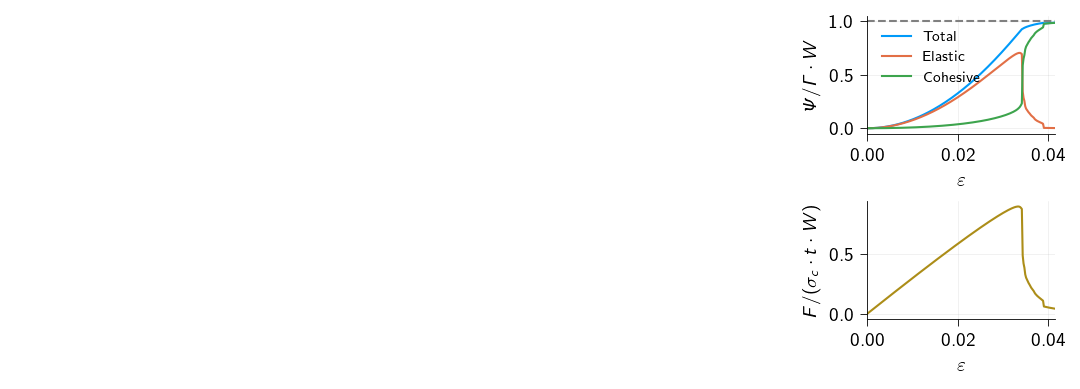

In [ ]:
Gamma_W = cohesive_mat.Gamma * (Lx - crack_length) * Lz

fig, axs = plt.subplots(2, 4, figsize=set_size(height_ratio=0.7, subplots=(2, 4)), layout='constrained', 
                        gridspec_kw={'width_ratios': [1, 1, 1, 0.75]})

axs[0, 0].set_axis_off()
axs[0, 1].set_axis_off()
axs[1, 0].set_axis_off()
axs[1, 1].set_axis_off()
axs[0, 2].set_axis_off()
axs[1, 2].set_axis_off()

axs[0, -1].plot(
    np.array(displacement_on_top)/height/2,
    (np.array(energies["elastic"]) + np.array(energies["cohesive"]))/Gamma_W,
    markevery=5,
    label="Total",
)
axs[0, -1].plot(np.array(displacement_on_top)/height/2, np.array(energies["elastic"])/Gamma_W, label="Elastic", markevery=5)
axs[0, -1].plot(np.array(displacement_on_top)/height/2, np.array(energies["cohesive"])/Gamma_W, label="Cohesive", markevery=5)

axs[0, -1].axhline(1, color="gray", zorder=-1, linestyle="--")
axs[0, -1].set_xlabel(r"$\varepsilon$")
axs[0, -1].set_ylabel(r"$\Psi/\Gamma\cdot{}W$")
axs[0, -1].grid(True)
axs[0, -1].set_xlim(0, np.array(displacement_on_top)[-80]/height/2)
axs[0, -1].grid(True)
axs[0, -1].legend(frameon=False, numpoints=1, markerscale=1.25)
axs[0, -1].spines['top'].set_visible(False)
axs[0, -1].spines['right'].set_visible(False)

axs[1, -1].plot(np.array(displacement_on_top)/height/2, np.array(force_on_top)/(sigma_c * Lz * (Lx - crack_length)), 
        color='#AC8D18')
axs[1, -1].set_xlabel(r"$\varepsilon$")
axs[1, -1].set_ylabel(r"$F/(\sigma_c \cdot t \cdot W)$")
axs[1, -1].grid(True)
axs[1, -1].set_xlim(0, np.array(displacement_on_top)[-80]/height/2)
axs[1, -1].spines['top'].set_visible(False)
axs[1, -1].spines['right'].set_visible(False)

plt.show()

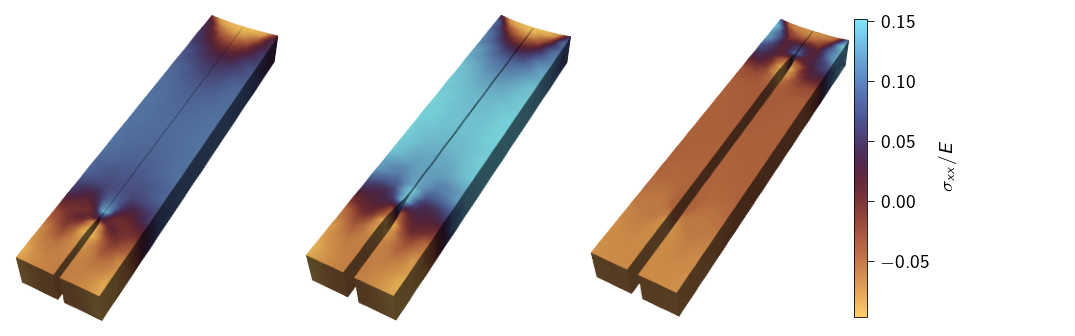

Vector-hybrid SVG saved to: ../figures/grid_render_cohesive.svg


In [ ]:
import matplotlib as mpl
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image


def get_render_and_colorbar(grid, grid_interface, values, u, sub_dim_in, dpi, step_idx=0, vmin=None, vmax=None):
    
    px_w, px_h = int(sub_dim_in[0] * dpi), int(sub_dim_in[1] * dpi)
    grid.point_data["u"] = u
    grid.cell_data["c"] = np.mean(np.array(values), axis=1) / E
    grid = grid.cell_data_to_point_data()
    grid = grid.warp_by_vector("u", factor=1.0)
    grid.set_active_scalars("c")

    pl = pv.Plotter(off_screen=True, window_size=[px_w, px_h])
    pl.set_background("white")
    pl.add_mesh(grid, scalars="c", component=0, cmap="managua", show_scalar_bar=False, smooth_shading=False)
    pl.view_vector([-0.85, -0.45, 1.0])
    #pl.camera.zoom(1.2)
    
    render_raw = Image.fromarray(pl.screenshot(None, return_img=True, transparent_background=True))
    img_3d = render_raw.crop(render_raw.getbbox())
    pl.close()

    c_min, c_max = np.min(grid.point_data["c"]), np.max(grid.point_data["c"])
    cb_artist = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap="managua")
    
    return img_3d, cb_artist


def generate_grid_svg(mesh, faces, values,u, vmin, vmax, steps_indices, subplots=(1, 3), filename="../figures/grid_render_cohesive.svg"):
    width_ratios = [1, 1, 1, 0.65]

    fig_dim_in = set_size(subplots=subplots, height_ratio=0.6) 
    fig, axs = plt.subplots(1, 4, figsize=fig_dim_in, layout='constrained', gridspec_kw={'width_ratios': width_ratios}, sharex=True)

    for i, step_idx in enumerate(steps_indices):
        img_3d, cb = get_render_and_colorbar(mesh, faces, values[step_idx], u[step_idx],
                                                  (fig_dim_in[0]/subplots[1] * width_ratios[i], fig_dim_in[1]/subplots[0]), 
                                                  dpi=400, step_idx=step_idx, vmin=vmin, vmax=vmax)
        
        axs[i].imshow(img_3d)
        axs[i].axis('off')
        if i < len(steps_indices) -1:
            continue

        cax = make_axes_locatable(axs[i]).append_axes("right", size="5%", pad="2%")
        fig.colorbar(cb, cax=cax, orientation='vertical', label=r"$\sigma_{xx}/E$")

    axs[-1].set_axis_off()

    plt.savefig(filename, format='svg', bbox_inches='tight', transparent=True)
    plt.savefig(filename.replace('.svg', '.pdf'), format='pdf',  bbox_inches='tight', transparent=True)
    plt.savefig(filename.replace('.svg', '.png'), format='png', dpi=300,  bbox_inches='tight', transparent=True)
    plt.show()
    plt.close(fig)

    print(f"Vector-hybrid SVG saved to: {filename}")

grid = pv.UnstructuredGrid(
    np.hstack((np.full((mesh.elements.shape[0], 1), 8), mesh.elements)).flatten(),
    np.full(mesh.elements.shape[0], pv.CellType.HEXAHEDRON),
    np.array(mesh.coords)
)

grid_interface = pv.UnstructuredGrid(
    np.hstack((np.full((interface_mesh.elements.shape[0], 1), 4), interface_mesh.elements)).flatten(),
    np.full(interface_mesh.elements.shape[0], pv.CellType.QUAD),
    np.array(interface_mesh.coords)
)

vmin = jnp.min(jnp.array(stresses_per_step)[:, :, 0, 0]) / E
vmax = jnp.max(jnp.array(stresses_per_step)[:, :, 0, 0]) / E


generate_grid_svg(grid, grid_interface, values=stresses_per_step, u=disp_per_step, vmin=vmin, vmax=vmax, steps_indices=[0, 6, -2], subplots=(2, 4))